In [1]:
import json
import numpy as np
import random
import sys
import gymnasium as gym
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

## **Hypeparameters**

In [2]:
OVERTIME_P = 1.0  # willingness of nurses to work overtime
ABSENCE_P = 1.0   # probability of absence

In [3]:
OFF_SHIFTS = ["resting", "absent", "standby"]

## **Nurse Class**

In [4]:
class Nurse():
    def __init__(self, id, index, assignments, contract_id, contract_details, shiftoffrequests, OVERTIME_P=OVERTIME_P):
        self.id = id      # ex: Nurse_1
        self.index = index       # ex: 0 (associated with place in JSON lists)
        
        self.overtime_shifts = 0 # nobody has overtime for now
        self.overtime_willingness = OVERTIME_P # always accept overtime
        
        # contract details
        self.contract_id = contract_id
        self.contract_details = contract_details
        self.max_assignments = self.contract_details["MaximumNumberOfAssignments"]
        
        # assignments
        self.assignments = [self.convert_shift(shift) for shift in assignments]
        self.num_assignments = len([x for x in self.assignments if x not in OFF_SHIFTS])
        self.remaining_available_days = self.max_assignments - self.num_assignments
        
        # shiftoffrequests
        self.shiftoffrequests = shiftoffrequests
    
    def convert_shift(self, shift):
        if shift == "A": 
            return "absent"
        elif shift == "S":
            return "standby"
        elif shift == "R":
            return "resting"
        else:
            return "working"
    
    def sample_overtime(self):
        # TODO: CHANGE TO DISTRIBUTION LATER
        return self.overtime_willingness

## **Scheduling Simulation Environment**

To make sure that the environment is compatible with `gym`, we will make the `SchedulingEnv` class inherit from `gym.Env`.

In [5]:
class SchedulingEnv(Env):
    def __init__(self, data_path, solution_path, OVERTIME_P=OVERTIME_P, ABSENCE_P=ABSENCE_P):
        """
        Properties of SchedulingEnv:
            self.data: data JSON
            self.solution: solution JSON
            self.NUM_DAYS: number of days in instance (int)
            self.NUM_NURSES: number of nurses in instance (int)
            self.shiftoffrequests: ???
            self.ALL_NURSEIDS_SET: set of all nurse ids - set(int)
            self.nurses_dict: {nurse id (string): nurse object (Nurse class)}
            self.nurse_status_dict: {status: set of nurse IDs per day (list)}
            self.init_state: NUM_DAYS x NUM_NURSES int matrix
            self.state: NUM_DAYS x NUM_NURSES int matrix
        """
        # Open JSONs
        with open(data_path) as f:
            self.data = json.load(f)
        with open(solution_path) as f:
            self.solution = json.load(f)

        self.NUM_DAYS = len(self.solution["Solution"][0]["Assignments"])
        self.NUM_NURSES = len(self.solution["Solution"])
        self.OVERTIME_P = OVERTIME_P
        self.ABSENCE_P = ABSENCE_P
        self.statuses = {"absent": 0, "working": 1, "standby": 2, "resting": 3}

        self.reset_env()
    
    def reset_env(self):
        self.init_shiftoffrequests()
        self.init_nurse_dict()
        self.init_nurse_status_dict()
        self.init_init_state()
    
    def init_shiftoffrequests(self):
        self.shiftoffrequests = dict()
        for request in self.data["Shiftoffrequests"]:
            if request["id"] not in self.shiftoffrequests:
                self.shiftoffrequests[request["id"]] = list()
            self.shiftoffrequests[request["id"]].append({request["day"]:request["shift"]})

    def parse_contract(self, contract_id):
        contract_details = {}
        if contract_id == "Contract_1":
            contract_details = self.data["Contracts"][0]
        elif contract_id == "Contract_2":
            contract_details = self.data["Contracts"][1]
        else:
            print("Invalid contract id.")
            sys.exit(1)
        return contract_details
    
    def init_nurse_dict(self):
        self.ALL_NURSEIDS_SET = set()
        self.nurses_dict = dict()
            
        # make nurse objects, stores shifts in list
        for index, nurse_sol in enumerate(self.solution["Solution"]):  
            nurse_id = nurse_sol["id"]
            assignments = [day["shift"] for day in nurse_sol["Assignments"]]
            contract_id = self.data["Nurses"][index]["contract_id"]
            contract_details = self.parse_contract(contract_id)
            if nurse_id in self.shiftoffrequests:
                nurse_requests = self.shiftoffrequests[nurse_id]
            else: nurse_requests = []
            
            # Add to nurse dictionary
            new_nurse = Nurse(nurse_id, index, assignments,contract_id, contract_details, nurse_requests, OVERTIME_P=OVERTIME_P)
            self.nurses_dict[nurse_id] = new_nurse
            
            # Add to nurse ID set
            self.ALL_NURSEIDS_SET.add(nurse_id) 

    def init_nurse_status_dict(self):
        self.nurse_status_dict = {
            status: [set(id for id, nurse in self.nurses_dict.items() if nurse.assignments[day] == status)
                    for day in range(self.NUM_DAYS)]
            for status in OFF_SHIFTS
        }

        self.nurse_status_dict["working"] = [set([id for id, nurse in self.nurses_dict.items() if nurse.assignments[day] not in OFF_SHIFTS]) 
                                            for day in range(self.NUM_DAYS)]
    
    def init_init_state(self):
        self.init_state = np.zeros((self.NUM_DAYS, self.NUM_NURSES), dtype=np.uint32)
        for status, days in self.nurse_status_dict.items():
            for day, nurses in enumerate(days):
                for nurse_id in nurses:
                    nurse = self.nurses_dict[nurse_id]
                    self.init_state[day][nurse.index] = self.statuses[status]

In [6]:
data_path = 'data/W1-01.json'
solution_path = 'solutions/sol-W1-01.json'

________________

## **Reinforcement Learning Model**

We define a new class, `RlSchedEnv` that inherits from our general `SchedulingEnv` class. This class is our RL environment, compatible with `gym`.

In [7]:
class RlSchedEnv(SchedulingEnv):
    def __init__(self, data_path, solution_path, ABSENCE_P=ABSENCE_P):
        super().__init__(data_path, solution_path, ABSENCE_P=ABSENCE_P)

        # Constants
        self.NUM_ACTIONS = 3 # 0: swap, 1: overtime, 2: no change
        self.NUM_STATUSES = 4 # 0: absent, 1: working, 2: standby, 3: resting
        self.statuses = {"absent": 0, "working": 1, "standby": 2, "resting": 3}
        self.rewards = {
            "swap success": 10,
            "swap fail": -1,
            "overtime success": 3,
            "overtime fail": -1,
            "unchanged": -5,
        }
    
        # Action and observation space
        self.action_space = spaces.Discrete(self.NUM_ACTIONS)
        self.observation_space = spaces.Box(low=0, high=self.NUM_STATUSES-1,
                                            shape=(self.NUM_DAYS, self.NUM_NURSES), 
                                            dtype=np.uint32)    
        self.reset()

    def step(self, action):
        self.sim_absence()
        # print("Day", self.curr_day, "Absent Nurse:", self.abs_nurse_id)

        # Take action to handle nurse absence
        if self.abs_nurse_id:
            # Attempt to swap shifts
            if action == 0:
                self.attempt_swap()
            # Request overtime
            elif action == 1:
                self.attempt_overtime()
            # No change
            elif action == 2:
                self.actions.append("Unchanged")
                self.reward += self.rewards["unchanged"]

            # Increment time step, limit to total number of days
            self.curr_day += 1
            if self.curr_day >= self.NUM_DAYS:
                self.terminated = True
                # print("Actions:", self.actions)
                # print("Final Reward:", self.reward)
                # print()
        else:
            self.actions.append("No Absence")
        
        # obs, reward, terminated, truncated, info
        return self.state, self.reward, self.terminated, False, {}

    def update_nurse(self, id, day, prev_status, new_status, change):
        """
        id: nurse id
        day: day of change
        prev_status: current status of nurse on specified day
        new_status: new status of nurse on specified day
        change: the increase in number of shifts
        """
        # Update nurse object
        nurse = self.nurses_dict[id]
        nurse.assignments[day] = new_status
        nurse.num_assignments += change
        nurse.remaining_available_days -= change

        # Update environment
        self.nurse_status_dict[prev_status][day].remove(id)
        self.nurse_status_dict[new_status][day].add(id)

        # Update state
        self.state[day][nurse.index] = self.statuses[new_status]

    def sim_absence(self):
        """
        Simulates a potential absence with probability `ABSENCE_P`.
        If an absence occurs, randomly selects one nurse to be absent
        for the current day and updates the state.
        """
        if random.random() < self.ABSENCE_P:
            self.abs_nurse_id = random.choice(list(self.nurse_status_dict["working"][self.curr_day]))
            self.update_nurse(self.abs_nurse_id, self.curr_day, "working", "absent", -1)
        else:
            self.abs_nurse_id = None
    
    def find_compatible_swap(self, statuses):
        """
        Returns nurse_id, swap_day, status if there is a compatible 
        swap with absent nurse on current day
        Else returns None, None, None
        """
        abs_nurse = self.nurses_dict[self.abs_nurse_id]
        for s in statuses:
            for id in self.nurse_status_dict[s][self.curr_day]:
                nurse = self.nurses_dict[id]
                # Skip overtime nurses
                if s == "resting" and nurse.remaining_available_days <= 0:
                    continue
                # Find a later day where nurse is working and absent nurse is not
                for day in range(self.curr_day+1, self.NUM_DAYS):
                    if nurse.assignments[day] == "working" and abs_nurse.assignments[day] != "working":
                        return id, day, s, abs_nurse.assignments[day]
                    
        return None, None, None, None
    
    def attempt_swap(self):
        nurse_id, swap_day, status, abs_status = self.find_compatible_swap(["standby", "resting"])
        if nurse_id is None:
            self.actions.append("Failed Swap")
            self.reward += self.rewards["swap fail"]
            return
    
        self.actions.append(status)
        self.reward += self.rewards["swap success"]
        
        # Update nurse schedules
        self.update_nurse(self.abs_nurse_id, swap_day, abs_status, "working", 1)
        self.update_nurse(nurse_id, self.curr_day, status, "working", 1)
        self.update_nurse(nurse_id, swap_day, "working", "absent", -1)

    def get_overtime_nurse(self):
        for id in self.nurse_status_dict["resting"][self.curr_day]:
            nurse = self.nurses_dict[id]
            # Only overtime nurses
            if nurse.remaining_available_days > 0:
                continue
            if random.random() < nurse.sample_overtime():
                return id
        return None

    def attempt_overtime(self):
        nurse_id = self.get_overtime_nurse()
        if not nurse_id:
            self.actions.append("Failed Overtime")
            self.reward += self.rewards["overtime fail"]
            return

        self.actions.append("overtime")
        self.reward += self.rewards["swap success"]
        self.update_nurse(nurse_id, self.curr_day, "resting", "working", 1)

    def reset(self, seed=None, options=None):
        self.reset_env()
        self.state = self.init_state.copy()
        self.terminated = False
        self.curr_day = 0 # timestep
        self.actions = []
        self.abs_nurse_id = None
        self.reward = 0
        return self.state, {}

In [8]:
env = RlSchedEnv(data_path, solution_path)
check_env(env)

/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:271: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [9]:
RL_model = PPO("MlpPolicy", env).learn(total_timesteps=30)

### **Results**

In [17]:
class RewardTrackingCallback(BaseCallback):
    """
    Custom callback to track episode rewards during training.
    """

    def __init__(self, verbose=0):
        super(RewardTrackingCallback, self).__init__(verbose)
        self.rewards = []

    def _on_step(self) -> bool:
        # Track rewards per episode
        if "infos" in self.locals:
            for info in self.locals["infos"]:
                if "episode" in info:
                    self.rewards.append(info["episode"]["r"])
        return True

    def _on_training_end(self) -> None:
        # Save rewards to analyze after training
        np.save("training_rewards.npy", self.rewards)


In [12]:
# Create an environment instance
env = RlSchedEnv(data_path, solution_path)

NUM_EPISODES = 500
TIMESTEPS = env.NUM_DAYS * NUM_EPISODES

# Instantiate the PPO model
model = PPO("MlpPolicy", env)

# Create the reward tracking callback
reward_callback = RewardTrackingCallback()

# Train the model with the callback
model.learn(total_timesteps=TIMESTEPS, callback=reward_callback)

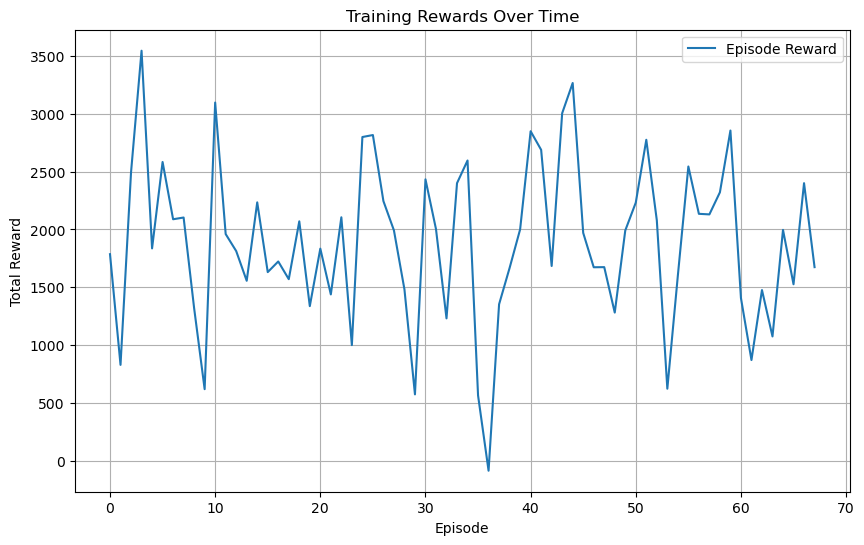

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Load the saved rewards
rewards = np.load("training_rewards.npy")

# Plot the rewards
plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Rewards Over Time")
plt.legend()
plt.grid(True)
plt.show()

_________________

## **Greedy Heuristic Model**

In [14]:
class GreedySchedEnv(SchedulingEnv):
    def __init__(self, data_path, solution_path):
        super().__init__(data_path, solution_path)
        # TODO: modify class